
<br>
Example illustrating the application of MBAR to compute a 1D free energy profile from an umbrella sampling simulation.<br>
The data represents an umbrella sampling simulation for the chi torsion of<br>
a valine sidechain in lysozyme L99A with benzene bound in the cavity.<br>
Reference:<br>
    D. L. Mobley, A. P. Graves, J. D. Chodera, A. C. McReynolds, B. K. Shoichet and K. A. Dill,<br>
    "Predicting absolute ligand binding free energies to a simple model site,"<br>
    Journal of Molecular Biology 371(4):1118-1134 (2007).<br>
    http://dx.doi.org/10.1016/j.jmb.2007.06.002<br>


In [3]:
import numpy as np

In [4]:
import pymbar  # multistate Bennett acceptance ratio
from pymbar import timeseries  # timeseries analysis
import matplotlib.pyplot as plt

Constants.

In [5]:
kB = 1.381e-23 * 6.022e23 / 1000.0  # Boltzmann constant in kJ/mol/K

In [6]:
temperature = 300  # assume a single temperature -- can be overridden with data from center.dat

Parameters

In [7]:
K = 26  # number of umbrellas
N_max = 501  # maximum number of snapshots/simulation
T_k = np.ones(K, float) * temperature  # inital temperatures are all equal
beta = 1.0 / (kB * temperature)  # inverse temperature of simulations (in 1/(kJ/mol))
chi_min = -180.0  # min for free energy profile
chi_max = +180.0  # max for free energy profile
nbins = 36  # number of bins for 1D free energy profile

Allocate storage for simulation data<br>
N_k[k] is the number of snapshots from umbrella simulation k

In [8]:
N_k = np.zeros([K], dtype=int)
# K_k[k] is the spring constant (in kJ/mol/deg**2) for umbrella simulation k
K_k = np.zeros([K])
# chi0_k[k] is the spring center location (in deg) for umbrella simulation k
chi0_k = np.zeros([K])
# chi_kn[k,n] is the torsion angle (in deg) for snapshot n from umbrella simulation k
chi_kn = np.zeros([K, N_max])
# u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
u_kn = np.zeros([K, N_max])
g_k = np.zeros([K])

Read in umbrella spring constants and centers.

In [9]:
with open("data/centers.dat") as infile:
    lines = infile.readlines()

In [10]:
for k in range(K):
    # Parse line k.
    line = lines[k]
    tokens = line.split()
    chi0_k[k] = float(tokens[0])  # spring center location (in deg)
    # spring constant (read in kJ/mol/rad**2, converted to kJ/mol/deg**2)
    K_k[k] = float(tokens[1]) * (np.pi / 180) ** 2
    if len(tokens) > 2:
        T_k[k] = float(tokens[2])  # temperature the kth simulation was run at.

In [11]:
beta_k = 1.0 / (kB * T_k)  # beta factor for the different temperatures
different_temperatures = True
if min(T_k) == max(T_k):
    # if all the temperatures are the same, then we don't have to read in energies.
    different_temperatures = False

Read the simulation data

In [12]:
for k in range(K):
    # Read torsion angle data.
    filename = f"data/prod{k:d}_dihed.xvg"
    print(f"Reading {filename}...")
    n = 0
    with open(filename, "r") as infile:
        for line in infile:
            if line[0] != "#" and line[0] != "@":
                tokens = line.split()
                chi = float(tokens[1])  # torsion angle
                # wrap chi_kn to be within [-180,+180)
                while chi < -180.0:
                    chi += 360.0
                while chi >= +180.0:
                    chi -= 360.0
                chi_kn[k, n] = chi
                n += 1
    N_k[k] = n
    if different_temperatures:  # if different temperatures are specified the metadata file,
        # then we need the energies to compute the free energy profile
        # Read energies
        filename = f"data/prod{k:d}_energies.xvg"
        print(f"Reading {filename}...")
        n = 0
        with open(filename, "r") as infile:
            for line in infile:
                if line[0] != "#" and line[0] != "@":
                    tokens = line.split()
                    # reduced potential energy without umbrella restraint
                    u_kn[k, n] = beta_k[k] * (float(tokens[2]) - float(tokens[1]))
                    n += 1

    # Compute correlation times for potential energy and chi
    # timeseries.  If the temperatures differ, use energies to determine samples; otherwise, use the cosine of chi
    if different_temperatures:
        g_k[k] = timeseries.statistical_inefficiency(u_kn[k, :], u_kn[k, 0 : N_k[k]])
        print(f"Correlation time for set {k:5d} is {g_k[k]:10.3f}")
        indices = timeseries.subsample_correlated_data(u_kn[k, 0 : N_k[k]])
    else:
        chi_radians = chi_kn[k, 0 : N_k[k]] / (180.0 / np.pi)
        g_cos = timeseries.statistical_inefficiency(np.cos(chi_radians))
        g_sin = timeseries.statistical_inefficiency(np.sin(chi_radians))
        print(f"g_cos = {g_cos:.1f} | g_sin = {g_sin:.1f}")
        g_k[k] = max(g_cos, g_sin)
        print(f"Correlation time for set {k:5d} is {g_k[k]:10.3f}")
        indices = timeseries.subsample_correlated_data(chi_radians, g=g_k[k])
    # Subsample data.
    N_k[k] = len(indices)
    u_kn[k, 0 : N_k[k]] = u_kn[k, indices]
    chi_kn[k, 0 : N_k[k]] = chi_kn[k, indices]

Reading data/prod0_dihed.xvg...
g_cos = 1.0 | g_sin = 1.2
Correlation time for set     0 is      1.193
Reading data/prod1_dihed.xvg...
g_cos = 1.2 | g_sin = 1.2
Correlation time for set     1 is      1.248
Reading data/prod2_dihed.xvg...
g_cos = 2.6 | g_sin = 2.5
Correlation time for set     2 is      2.550
Reading data/prod3_dihed.xvg...
g_cos = 4.1 | g_sin = 4.1
Correlation time for set     3 is      4.136
Reading data/prod4_dihed.xvg...
g_cos = 1.5 | g_sin = 1.4
Correlation time for set     4 is      1.462
Reading data/prod5_dihed.xvg...
g_cos = 2.5 | g_sin = 1.0
Correlation time for set     5 is      2.471
Reading data/prod6_dihed.xvg...
g_cos = 1.2 | g_sin = 1.4
Correlation time for set     6 is      1.357
Reading data/prod7_dihed.xvg...
g_cos = 1.5 | g_sin = 1.5
Correlation time for set     7 is      1.538
Reading data/prod8_dihed.xvg...
g_cos = 1.6 | g_sin = 1.6
Correlation time for set     8 is      1.584
Reading data/prod9_dihed.xvg...
g_cos = 1.6 | g_sin = 1.6
Correlation tim

In [13]:
N_max = np.max(N_k)  # shorten the array size
# u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kln = np.zeros([K, K, N_max])

Set zero of u_kn -- this is arbitrary.

In [14]:
u_kn -= u_kn.min()

compute bin centers

In [15]:
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(chi_min, chi_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])

In [16]:
N = np.sum(N_k)
chi_n = pymbar.utils.kn_to_n(chi_kn, N_k=N_k)

Evaluate reduced energies in all umbrellas

In [17]:
print("Evaluating reduced potential energies...")
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image torsion deviation from umbrella center l
        dchi = chi_kn[k, n] - chi0_k
        for l in range(K):
            if abs(dchi[l]) > 180.0:
                dchi[l] = 360.0 - abs(dchi[l])

        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k, :, n] = u_kn[k, n] + beta_k[k] * (K_k / 2.0) * dchi**2

Evaluating reduced potential energies...


initialize free energy profile with the data collected

In [18]:
fes = pymbar.FES(u_kln, N_k, verbose=True)
# Compute free energy profile in unbiased potential (in units of kT).
histogram_parameters = {}
histogram_parameters["bin_edges"] = bin_edges
fes.generate_fes(u_kn, chi_n, fes_type="histogram", histogram_parameters=histogram_parameters)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
center_f_i = results["f_i"]
center_df_i = results["df_i"]


******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************



Write out free energy profile

In [19]:
print("free energy profile (in units of kT), from histogramming")
print(f"{'bin':>8s} {'f':>8s} {'df':>8s}")
for i in range(nbins):
    print(f"{bin_center_i[i]:8.1f} {center_f_i[i]:8.3f} {center_df_i[i]:8.3f}")

free energy profile (in units of kT), from histogramming
     bin        f       df
  -175.0    0.889    0.083
  -165.0    3.104    0.131
  -155.0    5.986    0.166
  -145.0    8.875    0.249
  -135.0   11.387    0.275
  -125.0   12.438    0.350
  -115.0   11.830    0.371
  -105.0    9.570    0.374
   -95.0    6.535    0.376
   -85.0    4.123    0.381
   -75.0    2.538    0.386
   -65.0    2.015    0.400
   -55.0    2.586    0.403
   -45.0    3.745    0.409
   -35.0    5.739    0.419
   -25.0    8.190    0.423
   -15.0   11.119    0.425
    -5.0   14.051    0.436
     5.0   15.151    0.432
    15.0   13.669    0.431
    25.0   11.437    0.434
    35.0    8.833    0.436
    45.0    6.711    0.435
    55.0    5.371    0.439
    65.0    5.158    0.416
    75.0    6.132    0.384
    85.0    7.281    0.345
    95.0    8.170    0.318
   105.0    8.602    0.299
   115.0    8.903    0.283
   125.0    8.440    0.270
   135.0    7.413    0.262
   145.0    5.084    0.240
   155.0    2.585    0.17

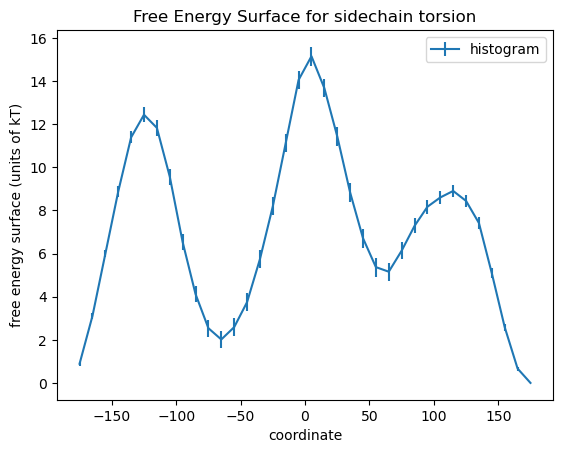

In [23]:
plt.errorbar(bin_center_i, center_f_i, yerr=center_df_i, label='histogram')
plt.title("Free Energy Surface for sidechain torsion")
plt.ylabel("free energy surface (units of kT)")
plt.xlabel("coordinate")
plt.legend()
plt.show()

NOW KDE:

In [ ]:
kde_parameters = {}
kde_parameters["bandwidth"] = 0.5 * ((chi_max - chi_min) / nbins)
fes.generate_fes(u_kn, chi_n, fes_type="kde", kde_parameters=kde_parameters)
results = fes.get_fes(bin_center_i, reference_point="from-lowest")
# Write out free energy profile from KDE
center_f_i = results["f_i"]
print("")
print("free energy profile (in units of kT), from KDE")
print(f"{'bin':>8s} {'f':>8s}")
for i in range(nbins):
    print(f"{bin_center_i[i]:8.1f} {center_f_i[i]:8.3f}")

{'f_i': array([ 0.88869887,  3.10416271,  5.98633396,  8.87498404, 11.38677227,
        12.43776352, 11.82971642,  9.56965467,  6.53493528,  4.12261821,
         2.53781449,  2.01496926,  2.58643134,  3.74469379,  5.73871338,
         8.1903128 , 11.11926694, 14.0507959 , 15.15090242, 13.66912185,
        11.43714563,  8.83304172,  6.71136155,  5.37108867,  5.1575965 ,
         6.13163259,  7.28113828,  8.17004344,  8.60164114,  8.90255641,
         8.4403168 ,  7.41346441,  5.08363308,  2.58500048,  0.6651784 ,
         0.        ]),
 'df_i': array([0.08324097, 0.13051363, 0.16563889, 0.24913442, 0.27510964,
        0.34958842, 0.37131722, 0.37405414, 0.37625307, 0.3809306 ,
        0.38597806, 0.40017207, 0.40262364, 0.4089418 , 0.41877737,
        0.42313654, 0.42488191, 0.43645455, 0.43173482, 0.43088464,
        0.43448815, 0.43625713, 0.43453981, 0.43871296, 0.4159114 ,
        0.3844612 , 0.34496014, 0.31825754, 0.29892136, 0.28340282,
        0.27002565, 0.26230664, 0.24024771,

In [ ]:
plt.errorbar(bin_center_i, center_f_i, yerr=center_df_i, label='histogram')
plt.title("Free Energy Surface for sidechain torsion")
plt.ylabel("free energy surface (units of kT)")
plt.xlabel("coordinate")
plt.legend()
plt.show()